In [1]:
import time
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

## Contents
1. **Data overwiew.** <br> _Overwiew of the raw data, some minor prep._
2. **Data arrangments.** <br> _Essential data arrangments for the task._
3. **Turnover analytics.** <br>_Aggregated turnover_<br>_Turnover in categories_
3. **Sellers analytics.** <br>_Best sellers across the buisness_<br>_Best seller by state_<br>_Worst seller by state_
3. **Products analytics.** <br>_Best selling product(s) by category_<br>_Best selling product(s) by category_

In this notebook, SQLAlchemy is used to retrieve data from the database.<br>
<br>
**What is SQLAlchemy?**<br>
SQLAlchemy is a Python library that essentially allows you to work with databases from the comfort of your notebook. It supports multiple Database Management Systems (DBMS) like SQLite, PostgreSQL, MySQL, and Oracle.<br><br>
Some details may vary with different database flavors, but the general idea is similar to our most simplified case, namely SQLite. First, let's create an engine and establish connection with our database and see some really basic info like the list of tables within our database.

In [2]:
from sqlalchemy import create_engine, inspect

# Create a database engine
engine = create_engine('sqlite:///transactional_data.db')
# Context manager is used to establish a connection
with engine.connect() as conn:
    # SQLAlchemy's Inspector is used to retrieve table names
    inspector = inspect(engine)
    table_names = inspector.get_table_names()
# Print the table names
print(table_names)

['order_items', 'order_reviews', 'orders', 'products', 'sellers']


Let's follow up on these tables and print out some essential details.

In [3]:
# Context manager is used to establish a connection
with engine.connect() as conn:
    inspector = inspect(engine)    
    for table_name in inspector.get_table_names():
        # Retrieve column information
        columns_info = inspector.get_columns(table_name)
        columns = [col['name'] for col in columns_info]        
        # Check for primary key
        primary_key = next((col['name'] for col in columns_info if col['primary_key']), None)        
        # Check for foreign keys
        foreign_keys_info = inspector.get_foreign_keys(table_name)
        foreign_key_columns = [fk['constrained_columns'][0] for fk in foreign_keys_info]        
        # Count the number of records in the table
        num_records_query = f"SELECT COUNT(*) FROM '{table_name}'"
        num_records = conn.execute(num_records_query).scalar()        
        # Print results
        print(f"\033[1m'{table_name}'\033[0m")
        print(f"Primary Key: {primary_key}")
        if foreign_key_columns:
            print("Foreign Key Column(s):")
            for fk_column in foreign_key_columns:
                print(f"  - {fk_column}")
        else:
            print("Foreign Key: None")
        print(f"Columns: {columns}")
        print(f"Number of Records: {num_records}\n")

'order_items'
Primary Key: order_items_pk
Foreign Key Column(s):
  - order_id
  - product_id
  - seller_id
Columns: ['order_items_pk', 'order_id', 'product_id', 'seller_id', 'price']
Number of Records: 110197

'order_reviews'
Primary Key: review_id
Foreign Key Column(s):
  - order_id
Columns: ['review_id', 'order_id', 'review_score', 'review_comment_message']
Number of Records: 39462

'orders'
Primary Key: order_id
Foreign Key: None
Columns: ['order_id', 'timestamp', 'customer_contact']
Number of Records: 96478

'products'
Primary Key: product_id
Foreign Key: None
Columns: ['product_id', 'product_category_name', 'product_weight_g']
Number of Records: 32216

'sellers'
Primary Key: seller_id
Foreign Key: None
Columns: ['seller_id', 'seller_state']
Number of Records: 2970



# 1) Data overwiew

In [4]:
# these four tables have what it takes to complete the analytics
sellers = pd.read_sql_query('SELECT * FROM sellers', engine, coerce_float=False)
products = pd.read_sql_query('SELECT * FROM products', engine, coerce_float=False)
orders = pd.read_sql_query('SELECT * FROM orders', engine, coerce_float=False)
order_items = pd.read_sql_query('SELECT * FROM order_items', engine, coerce_float=False)

In [5]:
def columns_info(df):
    # columns' basic metadata for a given df
    columns_info = {
        'column': df.columns,
        'dtype': [df[col].dtype for col in df.columns],
        'unique_val': [df[col].nunique() for col in df.columns]}
    columns_df = pd.DataFrame(columns_info)
    columns_df.set_index('column', inplace=True)
    columns_df.sort_values(by='unique_val', ascending=False, inplace=True)
    return columns_df

## 1.1) Sellers

**Dataframe columns description**:
* seller_id; PK, seller unique identifier.<br>
* seller_state; state of the seller.<br>

In [6]:
# basic dataframe info
sellers.shape, sellers.isnull().values.any()

((2970, 2), False)

In [7]:
columns_info(sellers)

,dtype,unique_val
column,,
seller_id,object,2970
seller_state,object,22


In [8]:
# container for analyzing sellers
sellers.set_index('seller_id', inplace=True)
sellers['turnover'] = 0
sellers['items_sold'] = 0
sellers.head(3)

,seller_state,turnover,items_sold
seller_id,,,
3442f8959a84dea7ee197c632cb2df15,SP,0,0
d1b65fc7debc3361ea86b5f14c68d2e2,SP,0,0
ce3ad9de960102d0677a81f5d0bb7b2d,RJ,0,0


## 1.2) Products

**Dataframe columns description**:
* product_id; PK, product unique identifier.<br>
* product_category_name; root category of product, in Portuguese.<br>
* product_weight_g; product weight measured in grams.

In [9]:
# basic dataframe info
products.shape, products.isnull().values.any()

((32216, 3), True)

In [10]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32216 entries, 0 to 32215
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32216 non-null  object 
 1   product_category_name  32216 non-null  object 
 2   product_weight_g       32214 non-null  float64
dtypes: float64(1), object(2)
memory usage: 755.2+ KB


In [11]:
products['product_weight_g'].fillna(products['product_weight_g'].mean(), inplace=True)
columns_info(products)

,dtype,unique_val
column,,
product_id,object,32216
product_weight_g,float64,2172
product_category_name,object,74


In [12]:
# container for analyzing products
products.set_index('product_id', inplace=True)
products['turnover'] = 0
products['items_sold'] = 0
products['recent_price'] = 0
products.head(3)

,product_category_name,product_weight_g,turnover,items_sold,recent_price
product_id,,,,,
1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,0,0,0
3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,0,0,0
96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,0,0,0


NOTE: 'recent_price' column is added due to price movements overtime:

In [13]:
# products prices are not rigid
unique_prices_per_product = order_items.groupby('product_id')['price'].nunique()
rows_with_multiple_prices = order_items[order_items['product_id'].isin(unique_prices_per_product[unique_prices_per_product != 1].index)]
rows_with_multiple_prices.set_index('product_id', inplace=True)
rows_with_multiple_prices.loc[rows_with_multiple_prices.head(1).index].head()

,order_items_pk,order_id,seller_id,price
product_id,,,,
4244733e06e7ecb4970a6e2683c13e61,0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,58.9
4244733e06e7ecb4970a6e2683c13e61,8346,130898c0987d1801452a8ed92a670612,48436dade18ac8b2bce089ec2a041202,55.9
4244733e06e7ecb4970a6e2683c13e61,36646,532ed5e14e24ae1f0d735b91524b98b9,48436dade18ac8b2bce089ec2a041202,64.9
4244733e06e7ecb4970a6e2683c13e61,49108,6f8c31653edb8c83e1a739408b5ff750,48436dade18ac8b2bce089ec2a041202,58.9
4244733e06e7ecb4970a6e2683c13e61,55021,7d19f4ef4d04461989632411b7e588b9,48436dade18ac8b2bce089ec2a041202,58.9


## 1.3) Orders

**Dataframe columns description**:
* order_id; PK, unique identifier of the order.<br>
* customer_contact; unique identifier of the consumer.<br>
* timestamp; shows the purchase timestamp. 

In [14]:
# basic dataframe info
orders.shape, orders.isnull().values.any()

((96478, 3), False)

In [15]:
columns_info(orders)

,dtype,unique_val
column,,
order_id,object,96478
customer_contact,object,96478
timestamp,object,95956


In [16]:
orders.timestamp = pd.to_datetime(orders['timestamp'])
orders.set_index('timestamp', inplace=True)
orders.sort_index(inplace=True)
orders.head(3)

,order_id,customer_contact
timestamp,,
2016-09-15 12:16:38,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574
2016-10-03 09:44:50,3b697a20d9e427646d92567910af6d57,355077684019f7f60a031656bd7262b8
2016-10-03 16:56:50,be5bc2f0da14d8071e2d45451ad119d9,7ec40b22510fdbea1b08921dd39e63d8


## 1.4) Order items
A dataframe serving as a container for a set of items associated with each order, along with each item info like product_id, price etc. 

**Dataframe columns description**:
* order_items_pk; PK, row unique identifier.<br>
* order_id; FK, order unique identifier.<br>
* product_id; FK, product unique identifier.<br>
* seller_id; FK, seller unique identifier<br>
* price; item price

In [17]:
# basic dataframe info
order_items.shape, order_items.isnull().values.any()

((110197, 5), False)

In [18]:
columns_info(order_items)

,dtype,unique_val
column,,
order_items_pk,int64,110197
order_id,object,96478
product_id,object,32216
price,float64,5859
seller_id,object,2970


In [19]:
order_items.set_index('order_items_pk', inplace=True)
order_items.head(3)

,order_id,product_id,seller_id,price
order_items_pk,,,,
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0


# 2) Data arrangments

To track and analyze aggreagate turnover, 'product_turnover' dataframe is created.

In [20]:
# aggregate (all categories) demand container 
start_date = orders.index[0].strftime('%Y-%m-%d')
end_date = orders.index[-1].strftime('%Y-%m-%d')

datetime_index = pd.date_range(start=start_date, end=end_date, freq='D')
column_names = ['items_sold', 'turnover']

product_turnover = pd.DataFrame(0, index=datetime_index, columns=column_names)
product_turnover.head(3)

,items_sold,turnover
2016-09-15,0,0
2016-09-16,0,0
2016-09-17,0,0


To track and analyze turnover for each product_category, a dictionary 'categories' is created with a dedicated dataframe for each category.

In [21]:
categories = {}
for category in products.product_category_name.unique():
    categories[category] = pd.DataFrame(0, index=datetime_index, columns=column_names)

Now, we cycle through the orders dataframe to fill in the created containers:

In [22]:
%%time
for index, row in orders.iterrows():
    # dataframe for aggregate turnover analitycs
    product_turnover.items_sold[index.strftime('%Y-%m-%d')] += order_items[order_items.order_id == row.order_id].shape[0]
    product_turnover.turnover[index.strftime('%Y-%m-%d')] += order_items[order_items.order_id == row.order_id].price.sum()
    for item in order_items[order_items.order_id == row.order_id].iterrows():
        # dataframes for category turnover analitycs
        group = products.loc[item[1].product_id].product_category_name
        categories[group].items_sold[index.strftime('%Y-%m-%d')] += 1
        categories[group].turnover[index.strftime('%Y-%m-%d')] += item[1].price
        # sellers dataframe update
        sellers.loc[item[1].seller_id, 'items_sold'] += 1
        sellers.loc[item[1].seller_id, 'turnover'] += item[1].price
        # products dataframe update
        products.loc[item[1].product_id, 'items_sold'] += 1  
        products.loc[item[1].product_id, 'turnover'] += item[1].price
        products.loc[item[1].product_id, 'recent_price'] = item[1].price 

CPU times: user 39min 14s, sys: 504 ms, total: 39min 14s
Wall time: 39min 16s


# 3) Turnover analytics

We begin our analysis by concluding that the vast majority of the business is located in the state of 'SP'.

In [23]:
state_turnover = sellers.groupby('seller_state')['turnover'].sum()
total_turnover = state_turnover.sum()
state_share = state_turnover / total_turnover
state_share.sort_values(ascending=False).head(5)

seller_state
SP    0.643612
PR    0.093189
MG    0.073960
RJ    0.062066
SC    0.046409
Name: turnover, dtype: float64

## 3.1) Aggregated turnover
We can see that though turnover grew, now it rather resembles stagnation and, moreover, recently it does not look good as turnover sharply declined in last week. Also, it is worth denoting that a spike occured on 2017-11-24.

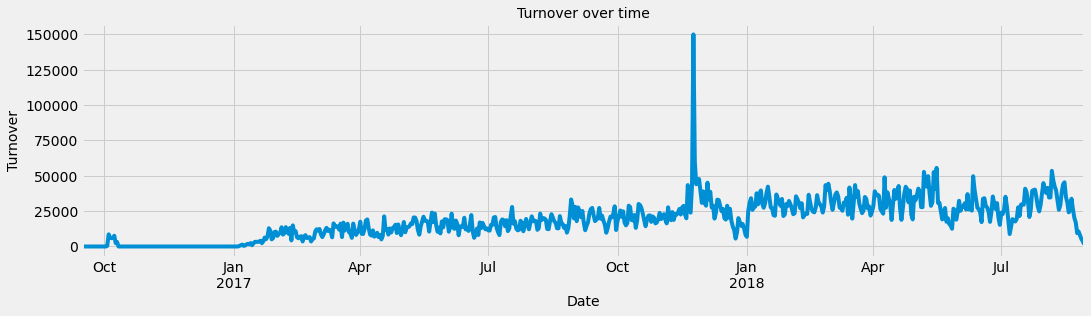

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

ax = product_turnover.turnover.plot(figsize=(16, 4))
ax.set_title('Turnover over time', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Turnover', fontsize=14)
plt.show()

Sudden spike in aggregated turnover on 2017-11-24.

In [25]:
product_turnover['2017-11-22':'2017-11-26']

,items_sold,turnover
2017-11-22,231,23951.51
2017-11-23,326,43102.33
2017-11-24,1345,149916.58
2017-11-25,569,59928.51
2017-11-26,450,44000.48


Concerning recent decline in aggregated turnover.

In [26]:
product_turnover.tail(10)

,items_sold,turnover
2018-08-20,282,33749.50
2018-08-21,257,26274.06
2018-08-22,215,20247.24
2018-08-23,161,17030.87
2018-08-24,115,9440.71
2018-08-25,75,10599.41
2018-08-26,82,8070.71
2018-08-27,71,5345.91
2018-08-28,45,3673.91
2018-08-29,16,1546.04


## 3.2) Turnover in categories
We will calculate the slope coefficient for each category to better understand the turnover and its trends within each category. Note that the calculations below are conducted starting from 2018-01-01, to prevent the most turbulent initial period of business activity from influencing the slope coefficient.

In [27]:
from sklearn.linear_model import LinearRegression

slopes = {}
for key in categories.keys():
    categories[key] = categories[key]['2018-01-01':]
    categories[key]['Time'] = np.arange(len(categories[key].index))
    X = categories[key].loc[:, ['Time']]  
    y = categories[key].loc[:, 'turnover']
    model = LinearRegression()
    model.fit(X, y)
    slopes[key] = model.coef_[0]

### Categories grownig since 2018

In [28]:
for key in slopes.keys():
    if slopes[key] > 0:
        print('slope_coeff: {}, sample points: {}, category: {}'.format(round(slopes[key], 2), 
                                                                        categories[key].items_sold.sum(), 
                                                                        key))

slope_coeff: 0.76, sample points: 1606, category: perfumaria
slope_coeff: 0.02, sample points: 165, category: artes
slope_coeff: 4.81, sample points: 3969, category: utilidades_domesticas
slope_coeff: 0.08, sample points: 519, category: eletrodomesticos
slope_coeff: 5.97, sample points: 5841, category: beleza_saude
slope_coeff: 0.75, sample points: 2580, category: automotivo
slope_coeff: 2.71, sample points: 2293, category: telefonia
slope_coeff: 1.33, sample points: 72, category: pcs
slope_coeff: 0.29, sample points: 454, category: casa_construcao
slope_coeff: 1.48, sample points: 3628, category: relogios_presentes
slope_coeff: 2.27, sample points: 787, category: construcao_ferramentas_construcao
slope_coeff: 1.97, sample points: 1146, category: pet_shop
slope_coeff: 0.41, sample points: 239, category: moveis_sala
slope_coeff: 0.39, sample points: 153, category: sinalizacao_e_seguranca
slope_coeff: 0.12, sample points: 308, category: livros_interesse_geral
slope_coeff: 0.33, sample po

### Categories in decline since 2018

In [29]:
for key in slopes.keys():
    if slopes[key] < 0:
        print('slope_coeff: {}, sample points: {}, category: {}'.format(round(slopes[key], 2), 
                                                                        categories[key].items_sold.sum(),
                                                                        key))

slope_coeff: -6.21, sample points: 4436, category: esporte_lazer
slope_coeff: -1.62, sample points: 1731, category: bebes
slope_coeff: -0.41, sample points: 393, category: instrumentos_musicais
slope_coeff: -3.51, sample points: 1447, category: cool_stuff
slope_coeff: -1.27, sample points: 4051, category: moveis_decoracao
slope_coeff: -0.3, sample points: 1454, category: brinquedos
slope_coeff: -1.69, sample points: 5810, category: cama_mesa_banho
slope_coeff: -0.18, sample points: 143, category: construcao_ferramentas_seguranca
slope_coeff: -9.43, sample points: 4622, category: informatica_acessorios
slope_coeff: -1.2, sample points: 487, category: malas_acessorios
slope_coeff: -1.25, sample points: 1849, category: ferramentas_jardim
slope_coeff: -2.17, sample points: 870, category: moveis_escritorio
slope_coeff: -0.93, sample points: 1837, category: eletronicos
slope_coeff: -0.02, sample points: 70, category: fashion_calcados
slope_coeff: -1.87, sample points: 1501, category: papelar

# 4) Sellers analytics

## 4.1)  Best sellers across the buisness

In [30]:
sellers.sort_values(by='turnover', ascending=False).head(15)

,seller_state,turnover,items_sold
seller_id,,,
4869f7a5dfa277a7dca6462dcf3b52b2,SP,226987.93,1148
53243585a1d6dc2643021fd1853d8905,BA,217940.44,400
4a3ca9315b744ce9f8e9374361493884,SP,196882.12,1949
fa1c13f2614d7b5c4749cbc52fecda94,SP,190917.14,579
7c67e1448b00f6e969d365cea6b010ab,SP,186570.05,1355
7e93a43ef30c4f03f38b393420bc753a,SP,165981.49,322
da8622b14eb17ae2831f4ac5b9dab84a,SP,159816.87,1548
7a67c85e85bb2ce8582c35f2203ad736,SP,139658.69,1155
1025f0e2d44d7041d6cf58b6550e0bfa,SP,138208.56,1420


## 4.2) Best seller by state

In [31]:
for state in sellers.seller_state.unique():
    if sellers[sellers.seller_state==state].shape[0] == 1:
        continue
    state_data = sellers[sellers.seller_state==state]
    state_data.sort_values(by='turnover', ascending=False, inplace=True)
    print('State: {}, seller_id: {}, turnower: {}'.format(state, state_data.head(1).index[0], round(state_data.head(1).turnover.values[0], 2)))
print('\nOnly single seller:')
for state in sellers.seller_state.unique():
    if sellers[sellers.seller_state==state].shape[0] == 1:
        print('State: {}, seller_id: {}, turnower: {}'.format(state, 
                                                              sellers[sellers.seller_state==state].index[0], 
                                                              round(sellers[sellers.seller_state==state].turnover.values[0], 2)))

State: SP, seller_id: 4869f7a5dfa277a7dca6462dcf3b52b2, turnower: 226987.93
State: RJ, seller_id: 46dc3b2cc0980fb8ec44634e21d2718e, turnower: 122811.38
State: PE, seller_id: de722cd6dad950a92b7d4f82673f8833, turnower: 55126.3
State: PR, seller_id: ccc4bbb5f32a6ab2b7066a4130f114e3, turnower: 72926.72
State: GO, seller_id: 9d5a9018aee56acb367ba9c3f05d1d6a, turnower: 10119.98
State: SC, seller_id: 04308b1ee57b6625f47df1d56f00eedf, turnower: 58991.8
State: BA, seller_id: 53243585a1d6dc2643021fd1853d8905, turnower: 217940.44
State: DF, seller_id: 44073f8b7e41514de3b7815dd0237f4f, turnower: 18380.64
State: RS, seller_id: 87142160b41353c4e5fca2360caf6f92, turnower: 31095.98
State: MG, seller_id: a1043bafd471dff536d0c462352beb48, turnower: 99309.23
State: RN, seller_id: 02d35243ea2e497335cd0f076b45675d, turnower: 5794.0
State: MT, seller_id: 2dee2ce60de9709b1a24083217181a1f, turnower: 7784.5
State: CE, seller_id: bbf9ad41dca6603e614efcdad7aab8c4, turnower: 7846.0
State: PB, seller_id: a6bd7d1c

## 4.3) Worst seller by state

In [32]:
for state in sellers.seller_state.unique():
    if sellers[sellers.seller_state==state].shape[0] == 1:
        continue
    state_data = sellers[sellers.seller_state==state]
    state_data.sort_values(by='turnover', ascending=True, inplace=True)
    print('* State: {}'.format(state))
    for index, row in state_data[state_data.turnover==state_data.head(1).turnover[0]].iterrows():
        print('  seller_id: {}, turnover: {}'.format(index, round(row.turnover, 2)))
print('\nOnly single seller:')
for state in sellers.seller_state.unique():
    if sellers[sellers.seller_state==state].shape[0] == 1:
        print('State: {}, seller_id: {}, turnower: {}'.format(state, 
                                                              sellers[sellers.seller_state==state].index[0], 
                                                              round(sellers[sellers.seller_state==state].turnover.values[0], 2)))

* State: SP
  seller_id: 77128dec4bec4878c37ab7d6169d6f26, turnover: 6.5
* State: RJ
  seller_id: c18309219e789960add0b2255ca4b091, turnover: 9.9
* State: PE
  seller_id: 70c0fda4c313d87115644d39e62eec60, turnover: 25.99
* State: PR
  seller_id: 95cca791657aabeff15a07eb152d7841, turnover: 9.99
* State: GO
  seller_id: 3aa3c89ae3cd482385568be76120f63c, turnover: 29.9
* State: SC
  seller_id: ad14615bdd492b01b0d97922e87cb87f, turnover: 8.25
* State: BA
  seller_id: 43753b27d77860f1654aa72e251a7878, turnover: 23.9
* State: DF
  seller_id: 43b2c864251aa0ce4030c746984e088a, turnover: 94.8
* State: RS
  seller_id: fb503a924a0b9db19d83dd0ac6dbef8c, turnover: 13.9
* State: MG
  seller_id: 702835e4b785b67a084280efca355756, turnover: 7.6
* State: RN
  seller_id: 392f7f2c797e4dc077e4311bde2ab8ce, turnover: 52.0
* State: MT
  seller_id: 1e9d5a33694bddb76316fd1f54734d20, turnover: 318.0
* State: CE
  seller_id: d4828feed4cda2cd9d6b37899a95a71e, turnover: 39.9
* State: PB
  seller_id: 739c7d7be81f63

# 5) Products analytics

## 5.1) Best selling product(s) by category

In [33]:
for category in products.product_category_name.unique():
    if products[products.product_category_name==category].shape[0]==1:
        continue
    category_data = products[products.product_category_name==category]
    category_data.sort_values(by='items_sold', ascending=False, inplace=True)
    print('* Category: {}'.format(category))
    for index, row in category_data[category_data.items_sold==category_data.head(1).items_sold[0]].iterrows():
        print('  product_id: {}, items_sold: {}'.format(index, row.items_sold))
print('* Single product in a category:')
for category in products.product_category_name.unique():
    if products[products.product_category_name==category].shape[0]==1:
        print('  product_id: {}, items_sold: {}, category: {}'.format(products[products.product_category_name==category].index[0], 
                                                                    products[products.product_category_name==category].items_sold[0],
                                                                    category))

* Category: perfumaria
  product_id: 2028bf1b01cafb2d2b1901fca4083222, items_sold: 132
* Category: artes
  product_id: 4fe644d766c7566dbc46fb851363cb3b, items_sold: 105
* Category: esporte_lazer
  product_id: c6336fa91fbd87c359e44f5dca5a90ed, items_sold: 92
* Category: bebes
  product_id: cac9e5692471a0700418aa3400b9b2b1, items_sold: 88
* Category: utilidades_domesticas
  product_id: 42a2c92a0979a949ca4ea89ec5c7b934, items_sold: 177
* Category: instrumentos_musicais
  product_id: 738da8ddda2e593acfdc53c2d1520dfa, items_sold: 23
* Category: cool_stuff
  product_id: c6dd917a0be2a704582055949915ab32, items_sold: 120
* Category: moveis_decoracao
  product_id: aca2eb7d00ea1a7b8ebd4e68314663af, items_sold: 520
* Category: eletrodomesticos
  product_id: be837f2e0152a208d4386f4126d5bd7c, items_sold: 36
* Category: brinquedos
  product_id: 880be32f4db1d9f6e2bec38fb6ac23ab, items_sold: 99
* Category: cama_mesa_banho
  product_id: 99a4788cb24856965c36a24e339b6058, items_sold: 477
* Category: cons

## 5.2) Worst selling product(s) by category

In [34]:
for category in products.product_category_name.unique():
    if products[products.product_category_name==category].shape[0]==1:
        continue
    category_data = products[products.product_category_name==category]
    category_data.sort_values(by='items_sold', ascending=True, inplace=True)
    print('\n* Category: {}'.format(category))
    for index, row in category_data[category_data.items_sold==category_data.head(1).items_sold[0]].iterrows():
        print('  product_id: {}, items_sold: {}'.format(index, row.items_sold))
print('\n* Single product in a category:')
for category in products.product_category_name.unique():
    if products[products.product_category_name==category].shape[0]==1:
        print('  product_id: {}, items_sold: {}, category: {}'.format(products[products.product_category_name==category].index[0], 
                                                                    products[products.product_category_name==category].items_sold[0],
                                                                    category))


* Category: perfumaria
  product_id: 1e9e8ef04dbcff4541ed26657ea517e5, items_sold: 1
  product_id: 07fd41c7a725529fe1213508557e0f4b, items_sold: 1
  product_id: 009c09f439988bc06a93d6b8186dce73, items_sold: 1
  product_id: c8f6689f642d2ac60ff34490bb59fc9a, items_sold: 1
  product_id: 2b8d2d937f84136de5b941aba77d4bcc, items_sold: 1
  product_id: 4d8f78374f31cd4b4932c1f2a42c4674, items_sold: 1
  product_id: c5abb4a7296fc26dc57bccbe8ae2d677, items_sold: 1
  product_id: 605d9e1329e4d2e960090c8da53d9c86, items_sold: 1
  product_id: 28f486789a96800dc97bb98e780e6d31, items_sold: 1
  product_id: 0f6e214a2c5baab8c1ccb053a0829f13, items_sold: 1
  product_id: 0568858419b609bd068bec047de0a1c8, items_sold: 1
  product_id: 274a778944c803fb95ea5a5b2c50611b, items_sold: 1
  product_id: 72a97c271b2e429974398f46b93ae530, items_sold: 1
  product_id: 4033dc4f8f073776b3048ba040d67697, items_sold: 1
  product_id: 54df5de144ebb2166a494aa271142af2, items_sold: 1
  product_id: e53197022fd9f554e01b9cf4f3c9f249


* Category: artes
  product_id: 3aa071139cb16b67ca9e5dea641aaa2f, items_sold: 1
  product_id: 5299e0a0336b5839e2a0ccb0d3d589d1, items_sold: 1
  product_id: 9cf421049bcfaf6983bf0dfb40831a03, items_sold: 1
  product_id: a556987a68ce3f7240da198c00f0305d, items_sold: 1
  product_id: 38841dec90eddf2f43cdfabc48b3831a, items_sold: 1
  product_id: f3c5f7d4a6b87b94a7ce5fa1c1b2ca10, items_sold: 1
  product_id: a793f6312549f217138244dda30208c5, items_sold: 1
  product_id: dc7e6c809b71f69934396f954df16806, items_sold: 1
  product_id: 49ab5384de586d3e4efd9072c43d50be, items_sold: 1
  product_id: 2ea654ee9e83b7622ce3ac79ce772970, items_sold: 1
  product_id: 7d1a4ebaf97da87516f9b108af5bd3e3, items_sold: 1
  product_id: 159065411d54fa1f2232d949976883db, items_sold: 1
  product_id: 4b90d2bd65c83d4ad8a370c2cd3f277c, items_sold: 1
  product_id: 23aaf24124ff41ebd81163d245aae6f3, items_sold: 1
  product_id: 058755c380722a806fc5440093c2c5bf, items_sold: 1
  product_id: be9bf7ba4c99709e44c413d4ffe9dfa4, ite

  product_id: 47a465cc5e0ae0b5cfa55a76909639a3, items_sold: 1
  product_id: b9fc59d07b4a88505e53e11d17097cef, items_sold: 1
  product_id: 5b4341a1e617e4d33c3305158ff03c69, items_sold: 1
  product_id: aea9f47e0e6dea45f3ad01ce4528f1bf, items_sold: 1
  product_id: aea89e156fe6705b458e900a8790af90, items_sold: 1
  product_id: 590d6cb76092faa04d717fe406c66f88, items_sold: 1
  product_id: 82d5798b1ffcb66543a2f0d6198a3a07, items_sold: 1
  product_id: c04dddb81af9afac2798f81e0ca7eed6, items_sold: 1
  product_id: b8fdfcbb0ed03c62d197327a56593842, items_sold: 1
  product_id: e6a8a1b25dccfe76d339f9cd19be7779, items_sold: 1
  product_id: 9f51209599d82cd4c08f2d1c9442f507, items_sold: 1
  product_id: e9eca3b15e6ebb8296666ab1254b504e, items_sold: 1
  product_id: d5b4966c1008fe4450d7f00503c75026, items_sold: 1
  product_id: 8c34ab7fffe8c063bc8c6da88aa92185, items_sold: 1
  product_id: c75a872692395427a0cfe0cf90bc858f, items_sold: 1
  product_id: 4e04b7c4ec31cc8172cf3e5b863d34d0, items_sold: 1
  produc


* Category: utilidades_domesticas
  product_id: 9dc1a7de274444849c219cff195d0b71, items_sold: 1
  product_id: 78cee0468912540c91a02760c91481fd, items_sold: 1
  product_id: f7f9a91ba39234c9bb9c7b159806f4d9, items_sold: 1
  product_id: 894d3a43c12eefa5d5bf7e9d68520b68, items_sold: 1
  product_id: eb38a7604070a2b8465101ed53cba72b, items_sold: 1
  product_id: c5ac6d71e1684e3e768495f047b33379, items_sold: 1
  product_id: cb43d652e4e00474e1c20377a68a165a, items_sold: 1
  product_id: fcfe8ebda270478afa5867ec5e46e7be, items_sold: 1
  product_id: 74fb740804bb486f4ba27a0241b4e6e8, items_sold: 1
  product_id: fb927c44d15e24c578f85a862576fd88, items_sold: 1
  product_id: 1121a43969b79e65010c2a5cdd0dcb6c, items_sold: 1
  product_id: bd144d5290d032a564563d75e98be4e8, items_sold: 1
  product_id: e7ce29342574abe2fbf171df97fdb092, items_sold: 1
  product_id: 3207053643b68f43eed19750c0ad8157, items_sold: 1
  product_id: 03a22dc9d5b99f07ca366f91aa7f7e4b, items_sold: 1
  product_id: b2fb9a4023836f0368a79

  product_id: 4b2422ebbc6723e80f355b11b4d8fba0, items_sold: 1
  product_id: ede30543a08093f6211aae6c721fddc3, items_sold: 1
  product_id: 753d279facc7d9ca90f2e8bfb2bab052, items_sold: 1
  product_id: ee8138bcca833152a19543702228ee26, items_sold: 1
  product_id: 437caf429e4e9beec15877117a13bb45, items_sold: 1
  product_id: 9269d6409ec9f19cad883b2c1aa206d9, items_sold: 1
  product_id: e06eb527f0a6ce904044687bd2faa582, items_sold: 1
  product_id: 34dfc6386b7550503bd2e582ef45d041, items_sold: 1
  product_id: 705be5f57de9f02f46b9b2ac3f7ebc8a, items_sold: 1
  product_id: 12e3a68b273ba72f5b5d7bbf73bd16be, items_sold: 1
  product_id: 1c6cf85f4af5c2787a812d273b836c01, items_sold: 1
  product_id: 18becf80f3bb277fc07eee177b32cad2, items_sold: 1
  product_id: 3a98258169bd8ad50f374ba4e8bf94e1, items_sold: 1
  product_id: a224196b0b605fdffac1d9224f052ceb, items_sold: 1
  product_id: 478cf0d317ccab62d1483a637de8df14, items_sold: 1
  product_id: 2abf28861922ed5da75726c7f3eb58f4, items_sold: 1
  produc


* Category: moveis_decoracao
  product_id: b33e45187a97dab72b3c819e76efc972, items_sold: 1
  product_id: ab592db756fdbec7cc98b2cd91ed51d0, items_sold: 1
  product_id: 3a594e201c33eeb699e72b5fb9f48dd6, items_sold: 1
  product_id: f1b1c272713f21efd25aec03865dffe3, items_sold: 1
  product_id: 1c9c1e9c68e2311f81258433b7e0092b, items_sold: 1
  product_id: 6a25cafd9048b9e5c75635e17545bff6, items_sold: 1
  product_id: 793b8fa20a40b4b14c94ab9681bf13b5, items_sold: 1
  product_id: ba572ccfc6c650859ea32461831bed57, items_sold: 1
  product_id: 674479daa617984023f920fb23b7de94, items_sold: 1
  product_id: fd6d9e3d204e6e693f4edd48ac33487e, items_sold: 1
  product_id: 2731fcd394a537e7af870051621316b1, items_sold: 1
  product_id: 1c0c0093a48f13ba70d0c6b0a9157cb7, items_sold: 1
  product_id: 84de44e3c2ce8920c251f5d48aac6132, items_sold: 1
  product_id: 55ff52707f328833ed80ea342bbaa115, items_sold: 1
  product_id: d919227cdbfeb24430df4170b7367f2b, items_sold: 1
  product_id: fd979b0722a18a4fb9dfe333ee


* Category: eletrodomesticos
  product_id: 37cc742be07708b53a98702e77a21a02, items_sold: 1
  product_id: 828097693199c9c0da94cf532dd2427d, items_sold: 1
  product_id: 35ffbac108d291eae9a8df90f92f6fad, items_sold: 1
  product_id: e1165c7ceda460f9d14914648fc31631, items_sold: 1
  product_id: 615cdd12d2db03b570f68c5ac19ab026, items_sold: 1
  product_id: cea1262b2dd1dd56c1b4f1f1c19b14d4, items_sold: 1
  product_id: 16b5adf7a7890633a2642ea9bd8a9ea5, items_sold: 1
  product_id: 5d9090aa267e7bc806b62f257ce6fe52, items_sold: 1
  product_id: af54833766006d685742bf140e6f0086, items_sold: 1
  product_id: 8722afd14143e0192b2abbcee6fe2873, items_sold: 1
  product_id: f638a5563e72783a14acd5da63e6e372, items_sold: 1
  product_id: da2d389f29f1cb7e89b1174349e40567, items_sold: 1
  product_id: 0b9c9a5a9c9825ff5bdb295751784392, items_sold: 1
  product_id: ec9f54e0036a28f74cc88439e4f9168b, items_sold: 1
  product_id: 6db39def795b8e1cfff57328bb3869db, items_sold: 1
  product_id: 9c01566eb81b90cf2c8014cb71

  product_id: 1967439d121aa088ab92049dead980f4, items_sold: 1
  product_id: 5849aea6eb5573c99c98e52682bd94eb, items_sold: 1
  product_id: 0134eb6b933b7ebc0f9e24ae5abefaa0, items_sold: 1
  product_id: ff9dfd2acec3dff6be51b4d28bed8768, items_sold: 1
  product_id: 31a70a048673639e07f9c3848b590d8d, items_sold: 1
  product_id: b95366fcf5a371ace4acfe7d720b07d9, items_sold: 1

* Category: brinquedos
  product_id: 8c92109888e8cdf9d66dc7e463025574, items_sold: 1
  product_id: 7e68b55d4ee384bfda2b61c827d3f33f, items_sold: 1
  product_id: 02335f37af17baf50a91273e4bdc8ef4, items_sold: 1
  product_id: 144b8110f0a755915d67660ab747d9d6, items_sold: 1
  product_id: f745d12feec8eda8a2a4cd70bbb9a067, items_sold: 1
  product_id: b2717842efa4cfa2f813f3c59f187869, items_sold: 1
  product_id: 2929ca606d5307bc5c4867edd6875add, items_sold: 1
  product_id: 89387716a7138913d0233d899b959c04, items_sold: 1
  product_id: f4b915a1ffcc06f7c282fe1958bfccfa, items_sold: 1
  product_id: 572a90c3bb49f037f9400e6b5937e831

  product_id: 31e3036d804e63b859b964d0c8bf9ddf, items_sold: 1
  product_id: e52df1e744f358d08c58c2371609d616, items_sold: 1
  product_id: ebf969336461d98e41d31673d8af75ba, items_sold: 1
  product_id: 7a1fcafd251c9e1014d0e9a88a5fcc46, items_sold: 1
  product_id: dd2a86c701f0442fa851c5391a5b81fe, items_sold: 1
  product_id: b20e4519d195d80c6d81bf3963a43d5a, items_sold: 1
  product_id: baf59a3a8f15ea34f04394f44bad573a, items_sold: 1
  product_id: abafccbe06074c732dceed6675d5a7ac, items_sold: 1
  product_id: 3f9b660d70c2742b1dab6701075b9b63, items_sold: 1
  product_id: 97122ffa6827f94f62ce56f48e848ae7, items_sold: 1
  product_id: 9a8200a7f3448bfb18683080c03b54b1, items_sold: 1
  product_id: af680b3406a3179e4a4c2051c5384cfd, items_sold: 1
  product_id: c91d8f1735fd6207567a03390d4ee309, items_sold: 1
  product_id: c5d4587c8ff1775a879008a4f804eb70, items_sold: 1
  product_id: 9246f7bd279121747dcb909a41f44df2, items_sold: 1
  product_id: 9d717f96236e39a3dbe6326b9d51d681, items_sold: 1
  produc

  product_id: 66b7fa94628214c463164097cfbadb7c, items_sold: 1
  product_id: c68cb347b4ee03689ba20e2ff229fb1a, items_sold: 1
  product_id: 107235293b5479d6ec3861e1348ea633, items_sold: 1
  product_id: 54971206521793b44053a9c348d148c2, items_sold: 1
  product_id: ed4863e3b4fddea62d559b6aa0f4df4b, items_sold: 1
  product_id: f7fb8cbbcb9cd35f6fc536c77ae02ebe, items_sold: 1
  product_id: 715ff1d94c99db18163cae1eb40f9bb0, items_sold: 1
  product_id: 3626035966a7aaee90d68108caebd386, items_sold: 1
  product_id: 3daf6db466fe8366db873ecbb2fd45d6, items_sold: 1
  product_id: a9e0e7b3976de987fdbd2773ec699f0c, items_sold: 1
  product_id: aa56ab71ba080a7d38971fc64e9cb732, items_sold: 1
  product_id: c4c428c423b8dfbfeae8ecd499d9a048, items_sold: 1
  product_id: 7334d00edefdee21be7eefd05f5433f6, items_sold: 1
  product_id: 4d38e93bf8056fbb01a32e72f0257df8, items_sold: 1
  product_id: 880a54b4d8c28e6f7f519ae8caaa09db, items_sold: 1
  product_id: 4219bea6cb9e38ad99b7e380bc11fb16, items_sold: 1
  produc

  product_id: ab7be0a001c3104b4931ce39ed70857d, items_sold: 1
  product_id: 80a7857c3c116ce0a0c5489f07721f5f, items_sold: 1
  product_id: 6ca99f05e9c1952a6597264e87f01378, items_sold: 1
  product_id: 23ea3287091e8d1237bb93f92177a39b, items_sold: 1
  product_id: 386cb36cffc83f379c65f1329bd66508, items_sold: 1
  product_id: 71aff090388f23854bb21d91cfe11607, items_sold: 1
  product_id: 05d43e31ef4408f944a3de2d18b0f755, items_sold: 1
  product_id: 6d3dbba0d82ea4b0e3fae73f4afc35ea, items_sold: 1
  product_id: 36a0c4a620e0ae5660ddc2924d667b4a, items_sold: 1
  product_id: a3aa0dac689c5cca6fa93f0f4b541abd, items_sold: 1
  product_id: e23a34276c3979415a832cbd4d043952, items_sold: 1
  product_id: d07ac0112a80ce7475f0b59a170a3046, items_sold: 1
  product_id: 8527a4190bad5e8443739b3cdb19920b, items_sold: 1
  product_id: 064a939bcd597315cfda6c98ede1b4c3, items_sold: 1
  product_id: 00e4ded51458037ecda216453eb79d3c, items_sold: 1
  product_id: 6981cd5a9eded40aaf36e08db9ef4a7a, items_sold: 1
  produc

  product_id: c55c77207af4d2ce4b0c54740f4ee7f3, items_sold: 1
  product_id: 5e6935146c2d07b17b2ca0d3e98cb1f6, items_sold: 1
  product_id: c1a97b7dfb03db09a3736bd6f1eb9034, items_sold: 1
  product_id: dd2e425e371689b74d67c0bd6e739ea2, items_sold: 1
  product_id: 0c94b3b3e297c165f359c7cd62acc3da, items_sold: 1
  product_id: a44915c1c247c7de4b5ea38ae2fcf657, items_sold: 1
  product_id: c63aa9195696eccba5bebc6d7a20aedc, items_sold: 1
  product_id: a5c76443c27d925386c35fe3d6921bf6, items_sold: 1
  product_id: 1f2b3e5d739add9d4596ba6de24204d4, items_sold: 1
  product_id: 7facb0c1345658cbdc0850feaaae0678, items_sold: 1
  product_id: 0cbc07d4b85c30f4eb6394504185f8f5, items_sold: 1
  product_id: 317dba41947df9cb9fec77921ee2d22e, items_sold: 1
  product_id: 1010bcae3110d01e187c7fcf789207bc, items_sold: 1
  product_id: ed832a46332b37403eb8670e6bcb9ee1, items_sold: 1
  product_id: 1be6d38ae75d87f6ee74e1d8e7e5466d, items_sold: 1
  product_id: 5050cfa82dba6f455d0e91b798777f21, items_sold: 1
  produc


* Category: ferramentas_jardim
  product_id: e1d1d22e9f8122a4ec1533b032c12562, items_sold: 1
  product_id: 5eda929e3621fe903d57208a6939acf5, items_sold: 1
  product_id: 9cd4e242b488f919520445a0623cc055, items_sold: 1
  product_id: b155265e4297510af95358ac2018fbd0, items_sold: 1
  product_id: 11fb5797b3ae9cf31bc0fcb8d907979a, items_sold: 1
  product_id: bca5c45c40f5c10e76d44d5104ecb9b5, items_sold: 1
  product_id: 7fbbe412c783af7237d40b9145aa5a8b, items_sold: 1
  product_id: 9f82fdef2a36bb15d22d70af1aedb3ce, items_sold: 1
  product_id: b3d0dc381a72d9d125dcb88e31a3e00c, items_sold: 1
  product_id: 77feb885b9ca6c9b64934b33e3c0e15e, items_sold: 1
  product_id: 2b82632fc977852ca422e8bf3255912f, items_sold: 1
  product_id: 178c02376540dea14abfbcc1af483528, items_sold: 1
  product_id: 44414d55ce2808a7b8f3568a92d1484f, items_sold: 1
  product_id: 48f933e4480c7187cd28b1637ddca29f, items_sold: 1
  product_id: d9de30e71874dfe17522cbfbc5c72921, items_sold: 1
  product_id: 81a5ad77c14cd83d0c853e4c

  product_id: 80b391b2dc6c958ef3ad34fa7ee01423, items_sold: 1
  product_id: 966417aeccf613e8cc7d219fa89619aa, items_sold: 1
  product_id: 1b405b8c885afa80810433526fc2c5ec, items_sold: 1
  product_id: 55aa465efc1629771ef1f96d3b9784ab, items_sold: 1
  product_id: 25e4d8fec8c2188a87e8c0acfd179310, items_sold: 1
  product_id: c5c1c5b904f5571d76dc3f494d3440bd, items_sold: 1
  product_id: ba6f5d5d953687794a10f01691232bc3, items_sold: 1
  product_id: 616b8608587aed2e11f568e82ee10c58, items_sold: 1
  product_id: cea23cad4e8ca9963c82fbc9412741db, items_sold: 1
  product_id: 3ac618d307e5f58f1cb1f8b5e7195a28, items_sold: 1
  product_id: bc4238b1e940a1ddfc42b987157ec004, items_sold: 1
  product_id: 061885af8dbda5739d592a153655e574, items_sold: 1
  product_id: c6053fedf40a0bc4b96372c4fe9e14dc, items_sold: 1
  product_id: c1cf9e70caf906259c299fbea35418ef, items_sold: 1
  product_id: 93278713f25024bcab2ce87921bf8b87, items_sold: 1
  product_id: e3c74f07496dd02492854d89b277eebd, items_sold: 1
  produc


* Category: eletronicos
  product_id: f6f1acecb8770430b76a87fae1c522dc, items_sold: 1
  product_id: 3af48a958298d5d4663dd1f5237b7279, items_sold: 1
  product_id: b56bf84f9384a87a3fbadd486d165615, items_sold: 1
  product_id: ff60ce007cb42cd9786f49d262a97672, items_sold: 1
  product_id: 693f7bc4e67d0fe9736923ec0af7db3c, items_sold: 1
  product_id: bb97ffd9ad088f593995b5b26dc9c24e, items_sold: 1
  product_id: 701ecef2b9b7bc7890d896dd1a691656, items_sold: 1
  product_id: 3c1f7308f5aff5c8a335550b2f9d83ab, items_sold: 1
  product_id: d426c52017387e708aa9e72eb90797b2, items_sold: 1
  product_id: fe4cd3c795135b4f84e2da5a82ac84a8, items_sold: 1
  product_id: a94567e6e87ea78a1be38458e59847dd, items_sold: 1
  product_id: 141125957e8b78c5cf939c18077fa2f7, items_sold: 1
  product_id: 436620c465f757ba7b47dd580f3c1eb2, items_sold: 1
  product_id: 08370229eb4e5ce898bf2348a356b7b2, items_sold: 1
  product_id: f4135cbdece8245560f7be179533797a, items_sold: 1
  product_id: 42b0078ac04ecf8c99c00602edceebf

  product_id: d638526eedf894404e66103a19943771, items_sold: 1
  product_id: 63e51e65ec59b56039c6427eed73dcf0, items_sold: 1
  product_id: b7dbc7d6e73a828cc62756e693f48b7d, items_sold: 1
  product_id: 04c4239553c71aafb3b2b5f74f165210, items_sold: 1
  product_id: e8f732eea94996831b9af41525a9ce3d, items_sold: 1
  product_id: c073cc5c3c6cff45b33fda27f5f3f807, items_sold: 1
  product_id: 9fee00e0df0ae090525db9ad0dd73cb8, items_sold: 1
  product_id: 49e17e3b00f741e344c5a9dcbce8cf62, items_sold: 1
  product_id: f09e13fe0ac1c5524c93e59ed3a4eaac, items_sold: 1
  product_id: e0d89abf7cf8de31e5e7fa03ddba5e2d, items_sold: 1
  product_id: b3e16658e1e1fbe944594fd267c488d8, items_sold: 1
  product_id: 290ba8a3d628822483a2b87cd122c739, items_sold: 1
  product_id: 802b191477641b98e903230bcfaa2a47, items_sold: 1
  product_id: 74b2f8c612fd08658bfc51519631d5f2, items_sold: 1
  product_id: f3efd1d829b025dddc72baba33e17c19, items_sold: 1
  product_id: fa00124915804f23967ae06d7dfd5874, items_sold: 1
  produc

  product_id: 281a353d0819c43883117f23a99a8410, items_sold: 1
  product_id: 62f68be290c2e9c8403e306bd023041c, items_sold: 1
  product_id: bde17838f4e4b0da69933dc1d8e07598, items_sold: 1
  product_id: 1632189d4c3d9e64cf3fd110b93f1a19, items_sold: 1
  product_id: 156929d95f2ef8373a04db2cb82bc3e1, items_sold: 1
  product_id: b842a6c9c2c51a699729d378d8d674fc, items_sold: 1
  product_id: e2ec3791e11dff618b89719b7e264064, items_sold: 1
  product_id: dafcf8195acb775dcbfa9dae22b3c959, items_sold: 1
  product_id: b9a96cfeeea8e470af6d87627be50e10, items_sold: 1
  product_id: a968285b931b85e05c46234aa3db388f, items_sold: 1
  product_id: 165948b2c41e846df7d09b56826a747f, items_sold: 1
  product_id: fd3a4121e687a6b84e7af92606d5d718, items_sold: 1
  product_id: b3d4d6113e42b86ceb66060424125828, items_sold: 1
  product_id: 18344238d9024a2e2f3f549d5ab1fadc, items_sold: 1
  product_id: af79de12e005e141b22ab97c807e76d3, items_sold: 1
  product_id: 48465725d322101bdadd1d1a5acd8480, items_sold: 1
  produc

* Category: construcao_ferramentas_construcao
  product_id: 556702ebb73d3786a852ad3d5a8ad268, items_sold: 1
  product_id: e8a1dffbef0392ef084cca41655a13d1, items_sold: 1
  product_id: 4c8fae70c244a7ff63b9c1f73fb0a987, items_sold: 1
  product_id: 366980848ec5025f19199579ff57bd6d, items_sold: 1
  product_id: 85c35088e92ac74354061edbe3de0b74, items_sold: 1
  product_id: 3a5bfc952a6ad85598f16e431eb7622b, items_sold: 1
  product_id: c3da6347b3df112e52de0d6f9443158b, items_sold: 1
  product_id: 5096e827f6152df3974343e735a52dc9, items_sold: 1
  product_id: 4f74d757aae5755017f9afc37c65afa6, items_sold: 1
  product_id: d89b65ae21c1eed8128aafb8c3c553fe, items_sold: 1
  product_id: cecbcf63df5c478acc233d45ee32122a, items_sold: 1
  product_id: 6aafd3c0f3c474278b14545ef46bb99b, items_sold: 1
  product_id: cff0f92f00bc55eda3414e941101ccb9, items_sold: 1
  product_id: 6c1d133db7e26f35b03876c7f4c0177b, items_sold: 1
  product_id: 6164a01ab8ccd7fd2c68f5316aa8bec6, items_sold: 1
  product_id: aa050bcc1f


* Category: eletroportateis
  product_id: 278b3c6462e86b4556b99989513ddf73, items_sold: 1
  product_id: 9e91c1a0603362cd90caa2e9f6580bb7, items_sold: 1
  product_id: fa64259a73edf6f724b7ddf23aac1bb0, items_sold: 1
  product_id: 725a6c1520c48838212406e45e2ce4bb, items_sold: 1
  product_id: ec599713785663cb46e6cb801f28e5f8, items_sold: 1
  product_id: 9523bf75c55cbbd31a79ea86a9157a39, items_sold: 1
  product_id: 84ef572c9b97343b83ab437a3ad75461, items_sold: 1
  product_id: de617af7dcabcd4b1eb8855381250940, items_sold: 1
  product_id: 606a5b6dec14661643801e2cbf308b04, items_sold: 1
  product_id: ad02436dd1e1332d5f75dced36e0a73e, items_sold: 1
  product_id: 7912d0573817374a39cce127b79c4863, items_sold: 1
  product_id: fa6eebf61147fc40bc2b49765f5b877f, items_sold: 1
  product_id: 61ba71a0b111e24da5c8fd2f0e61b0c1, items_sold: 1
  product_id: 1e9f407b0d5f8f439956c66df050c107, items_sold: 1
  product_id: ffa0824a2b01e5ce24d6883413b72f14, items_sold: 1
  product_id: 1c955eb7c06e7330695a99212a9


* Category: livros_interesse_geral
  product_id: 8c9faf6aabee9b2a30b83f92d786f6de, items_sold: 1
  product_id: ff1b8d53a1563c1f27a3d99e740ceaa9, items_sold: 1
  product_id: b5fc56b0fd1d8e72bc4f4fa53215c16e, items_sold: 1
  product_id: 7254c9cf327a9283f9532eeeb1058eb3, items_sold: 1
  product_id: e04493d73e69a7e3f63e676d761750e2, items_sold: 1
  product_id: 778c4dffd777dbe97f26efe02565df49, items_sold: 1
  product_id: 055e4f6156ba6c0daab61cd40d5530fe, items_sold: 1
  product_id: c518e285e7aaff0537a2ad50dc3eceaa, items_sold: 1
  product_id: ed00c79b26683d1f8d4a6df605efe886, items_sold: 1
  product_id: fb6d1c0e458a83fe774bbdf52d704287, items_sold: 1
  product_id: c1aabbb6f4caec9f5bf7cd80519d6cc0, items_sold: 1
  product_id: 13d4517626b8f08688c28586123fd638, items_sold: 1
  product_id: 255ccdfcc84f0e16699f0916b72758e3, items_sold: 1
  product_id: f2263585f626f9ca5b825e449f583f3b, items_sold: 1
  product_id: c87d290a69f27d78e303df61eb85409b, items_sold: 1
  product_id: 1825f78fda454294d530


* Category: construcao_ferramentas_iluminacao
  product_id: 9138555a5066b7f16bf15e75c7db067c, items_sold: 1
  product_id: 7c433a3314f8ce018f386af369d96d61, items_sold: 1
  product_id: 01cb96c64e8e35f29826a58963f6ecc5, items_sold: 1
  product_id: 90d6c0080350ceabdb86561709163786, items_sold: 1
  product_id: e58a56ad705cc3e02d6db9ae1a16c406, items_sold: 1
  product_id: 17d4983a8766060a5977b2ea679617f6, items_sold: 1
  product_id: 2ed6a60d8d1687aa377a1d37746664eb, items_sold: 1
  product_id: 8e0be6304c4a94268be42e2d8dfaded9, items_sold: 1
  product_id: cfba8f6c12ed108481d6879597b7b521, items_sold: 1
  product_id: 8b8b30bd6b299fdb35de1da9e288014e, items_sold: 1
  product_id: 3d63afec955956d47d796237f6725cde, items_sold: 1
  product_id: 7d8859255a3df42a5358837fc88850a7, items_sold: 1
  product_id: 5b3e84d222c3b93e0967d608cefdd472, items_sold: 1
  product_id: bfea93163f55ed2b752b71963493ded8, items_sold: 1
  product_id: f7c98cd8b2d4d3b9a2d1322721e60a5a, items_sold: 1
  product_id: df9a33ada


* Category: artes_e_artesanato
  product_id: 43506d2b6b5e0535079f88c7dc51c4de, items_sold: 1
  product_id: 78eacca1151432fda7271e7e53e49720, items_sold: 1
  product_id: c51fd9478d188180d962c7ecc35b42d0, items_sold: 1
  product_id: eacb104882d39ffb53140b1d1860a7c3, items_sold: 1
  product_id: 3a96bcbf644a5d390107570628568026, items_sold: 1
  product_id: 56a1efb30499b4dffd45c8d655199b11, items_sold: 1
  product_id: ec90895370885d025efeb8e72e7fa699, items_sold: 1
  product_id: 5aa0d6ed4e6c0995d62090cd82cde89a, items_sold: 1
  product_id: c36f564e4c2baa5ed9d7bfa1a111c29c, items_sold: 1
  product_id: 6bb18295cc019bf3b6dc7c773411d530, items_sold: 1
  product_id: 08c5c3d471845327e913b52aded0caf3, items_sold: 1
  product_id: 9c313adb4b38a55b092f53f83f78be9e, items_sold: 1
  product_id: 2b54fb9a4acf707537eb53eb2458c241, items_sold: 1
  product_id: 4a24717893a6c8f3cfcf9843b8987d15, items_sold: 1
  product_id: 189d6b9a380642d0ee2245277cc9b2f2, items_sold: 1
  product_id: 1cf657de01c2b973b898ad0a